Imports.

In [1]:
import numpy as np
import torch
import platform
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
from lenet5 import LeNet5, lenet5_init_
from levenberg_marquadt_optim import DiagLM
import polars as pl
import random

In [2]:
print(torch.__version__, torch.cuda.is_available(), platform.python_version())
device = "mps" if torch.backends.mps.is_available() else "cpu"

2.7.1 False 3.12.1


shape: (10, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ i64   ┆ u32   │
╞═══════╪═══════╡
│ 0     ┆ 5923  │
│ 1     ┆ 6742  │
│ 2     ┆ 5958  │
│ 3     ┆ 6131  │
│ 4     ┆ 5842  │
│ 5     ┆ 5421  │
│ 6     ┆ 5918  │
│ 7     ┆ 6265  │
│ 8     ┆ 5851  │
│ 9     ┆ 5949  │
└───────┴───────┘


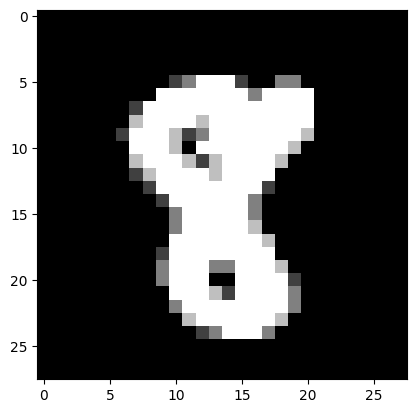

In [3]:
ds_train = MNIST(root=".", download=True, train=True, transform=ToTensor())

# flatten images / process data
labels = pl.Series(name="label", values=ds_train.targets)
print(labels.value_counts().sort("label"))

random_num = ds_train.data[random.randint(0, len(ds_train))]
plt.imshow(random_num.reshape((28, 28)), cmap="gray")
plt.show()

In [4]:
EPOCHS = 10
BATCH_SIZE = 256

In [20]:
train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
model = LeNet5().to(device)
opt = DiagLM(model.parameters(), lr=0.05) # we use SGD instead of Levenberg-Marquardt for simplicity
loss_fn = nn.CrossEntropyLoss()

Training Loop

In [ ]:
losses = np.zeros((len(train), EPOCHS))
for epoch in tqdm(range(EPOCHS)):
    running_loss = 0.0
    train_iter = iter(train)
    for sample_idx, (imgs, labels) in enumerate(train_iter):
        imgs = torch.nn.functional.pad(imgs, (2, 2, 2, 2), mode='constant', value=0).to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running_loss += loss.item()
        losses[sample_idx, epoch] = loss.item()
    avg = running_loss / len(train)

 10%|█         | 1/10 [00:03<00:29,  3.23s/it]

Epoch 1/10  |  loss: nan


 20%|██        | 2/10 [00:06<00:25,  3.24s/it]

Epoch 2/10  |  loss: nan


 30%|███       | 3/10 [00:09<00:22,  3.26s/it]

Epoch 3/10  |  loss: nan


 40%|████      | 4/10 [00:12<00:18,  3.06s/it]

Epoch 4/10  |  loss: nan


 50%|█████     | 5/10 [00:15<00:15,  3.05s/it]

Epoch 5/10  |  loss: nan


 60%|██████    | 6/10 [00:18<00:12,  3.10s/it]

Epoch 6/10  |  loss: nan


 70%|███████   | 7/10 [00:21<00:09,  3.13s/it]

Epoch 7/10  |  loss: nan


 80%|████████  | 8/10 [00:25<00:06,  3.12s/it]

Epoch 8/10  |  loss: nan


 90%|█████████ | 9/10 [00:28<00:03,  3.08s/it]

Epoch 9/10  |  loss: nan


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]

Epoch 10/10  |  loss: nan


In [18]:
# Load test dataset
ds_test = MNIST(root=".", download=True, train=False, transform=ToTensor())
test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# Evaluation Loop
model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for inference
    for imgs, labels in test:
        # Apply same padding as training
        imgs = torch.nn.functional.pad(imgs, (2, 2, 2, 2), mode='constant', value=0).to(device)
        labels = labels.to(device)
        
        # Forward pass
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        
        # Calculate accuracy
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        test_loss += loss.item()

# Calculate final metrics
avg_test_loss = test_loss / len(test)
accuracy = 100 * correct / total

print(f"Test Results:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {accuracy:.2f}% ({correct}/{total})")

Test Results:
  Test Loss: nan
  Test Accuracy: 0.00% (0/10000)
